## Advanced Regression Kaggle competion
aka Alex recommendations and best practices for model tuning. 

I made this notebook as a warmup for Kaggle-style data science. 
Before you get into Kaggle-style model tuning there are more important questions that a data scientist should ask:
1. How did I get this data? Is there some bias or systematic error that may mislead me in this dataset? Can I get more data or better data? For example by finding or scraping another related data source. The quality of the data is the most important thing. Your insights can be only as good as your data, so this usually the most important step in real life. 
2. What am I trying to achieve? What is the business-related metric I should be using? 
3. After you have decided on the dataset and the metric, we get into Kaggle-style model tuning. This is what this notebook is about. 
Note also that a few competitions allow you to combine external datasets.  We will study this topic later. 

This notebook requires the data files from the Advanced regression kaggle competion
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


For Kaggle-style model tuning, here are some recommended readings:

https://www.kaggle.com/apapiu/regularized-linear-models

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/

In [1]:
#Lets start by import some of our standard tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline

In [4]:
#Lets read the data
path = "/home/daniel/Documents/Fall_2018/DSL/DataScienceLab/lab3"
train = pd.read_csv(path + "/kaggle/train.csv")
test = pd.read_csv(path + "/kaggle/test.csv")

In [5]:
#The first thing you always do is LOOK at the data. Lets start with shapes
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

Ok, there are 1460 labeled examples in the training 
set and 1459 in the test set. Lets look more carefully.

In [7]:
test.head()  #You should always do that.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Each row is a house, and we have features like MSSubClass, MSZoning, LotFrontage (that one is easy to understand) and many other features. It is important to understand what your features are. For this competition the file data_description.txt explains, for example, that MSSubClass is the type of house in that sale, e.g. 20 = 1-story house built in 1946 or newer, while code 30 is 1-story house build before 1945, etc. Similarly, MSZoning being RL means 'Residential low density' while 'RH' means 'Residential High-density', etc.  

We need to feed these features into models so we have to go from categorical features to vectors of numbers. There are many ways to encode categorical features and we will talk about this in class. The standard easy first method is called one-hot encoding (aka dummy variables). You replace one categorical feature with multiple columns that are 0 or 1. For MSZoning we will be adding a columns meaning MSZoning_Is_RH, MSZoning_Is_RL, etc. 

You can write manual code to do this, but pandas gives you the method get_dummies which is convenient. 

In [8]:
testdum= pd.get_dummies(test)  #Ok lets try to run it, to see what it does. 

In [9]:
testdum.shape  #And then we look

(1459, 271)

So the test dataframe had 1459 examples and we still have 1459 rows so that is good news. 
The 80 features have been replaced by 271 features. 
This should should include the number of possible values that the categorical features take, 
while leaving the numerical features alone. Lets look more carefully.


In [10]:
testdum.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


You see the column MSZoning is gone but the columns with numbers remain. You need to go find where they are if they have the names you expect

In [11]:
list(testdum.columns.values)   #This actually lists all the columns

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'Lan

If you scroll down in the feature names you will find 'MSZoning_RH' and 'MSZoning_RL' 
as we were expecting. This is good news. You should check that indeed the row which had MSZoning being RH has indeed MSZoning_RH=1 and the other options =0

There one important mistake we have done here. Do you see it? 

The feature MSSubClass has remained numerical in testdum. 
This is because the get_dummies method did not understand that the numbers 20,30 etc do not represent codes of a categorical variable. You should be one-hot encoding that column too. Find how to do that. 

The next step is to look at how the statistics of the features look like.

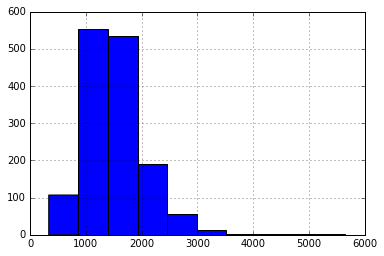

In [12]:
train.GrLivArea.hist()  #this plots the histogram of the feature LotFrontage.

Most homes are between 1000 to 3000 square feet. This is reasonable. 

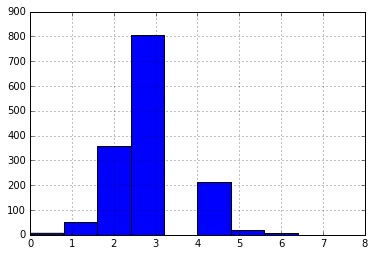

In [13]:
#Lets investigate how many bedrooms there are.
train.BedroomAbvGr.hist()  #This is the number of Bedrooms above grade (i.e. not basement bedrooms)

Hmm, this is odd. Why is this gap there. Lets look at the actual values of the feature.

In [14]:
train.BedroomAbvGr.value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

Ok, it was the way the histogram bins integers then, lets not worry about it.
There is an 8 bedroom house, that seems odd. Lets find it to look if this is an outlier or error. 

I want to select the row of the train dataframe that has BedroomAbvGr=8. I can do it with one line of pandas slicing

In [15]:
train[ train.BedroomAbvGr==8]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


In [16]:
#Uh, it does not show me all the columns. I can fix that in many ways.
#We'll change the number of max_columns:
pd.set_option('display.max_columns',300)    
train[ train.BedroomAbvGr==8] #ok lets see now.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Feedr,Norm,2fmCon,2.5Fin,6,7,1914,1995,Hip,CompShg,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,TA,Fa,No,LwQ,256,Unf,0,1184,1440,GasA,Ex,Y,FuseA,1440,1440,515,3395,0,0,2,0,8,2,Fa,14,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,110,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


From the data description we read that MSsubClass=190 means this is a '2 family conversion, all styles' home.
The Neighborhood is SWISU (South and West of Iowa State University).
House style is 2.5Fin (Two and one-half story house) built in 1914.
Has TotRmsAbvGrd = 14 (thats a lot of rooms), only 2 full bathrooms and 2 Kitchens which are unfortunately of quality 'Fa' (Fair). 

Lets check how big it is overall.

In [17]:
train[ train.BedroomAbvGr==8].GrLivArea #total square feet except basement

635    3395
Name: GrLivArea, dtype: int64

So my conclusion here is that this is a pretty large old house. 
Probably 8 bedrooms is not an error, so lets leave it alone. 

## Data cleaning and feature normalization. 

We are trying to predict the sales price. Lets look at its statistics. 

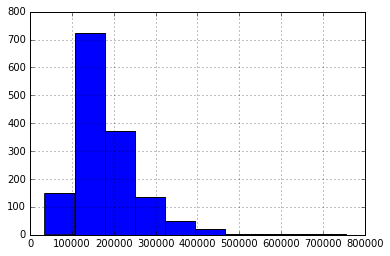

In [18]:
train.SalePrice.hist()

This is a very skewed distibution. It has a high dynamic range. 
Alex recommends that when you are predicting 
a variable with high dynamic range, 
it is better to predict its logarithm instead. 
Engineers discovered that and introduced the Decibel (dB) scale.
See also this https://www.youtube.com/watch?v=_p-WyPg1sbU for fun. 

Its best to use log1p i.e. logarithm of 1 plus the quantity (for non-negative features). the 1+ ensures that features that are 0 do not make the logarithm explode. 


In [19]:
# Some data cleaning 

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [20]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,Garage

You see that we have taken logarithms of skewed features.
Unfortunately that even included the (categorical, numerically coded) MSSubclass 
so this part should be improved. 
This part is called feature engineering. There is a big art to it, that is specific to the data science problem at hand. 
We will not move into the next step which is actually training and tuning models. 


## Training and Tuning models

#### Lets start with a simple Ridge regression

You can read more about Ridge regression here

http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

In [21]:
from sklearn.linear_model import Ridge

model1= Ridge(alpha=1.0)  #Alpha is the hyperparameter for the amount of regularization

#Machine learning in two lines of code, lol.
model1.fit(X_train, y)  #Train 
yhat= model1.predict(X_train)  #Run model on train set to make predictions

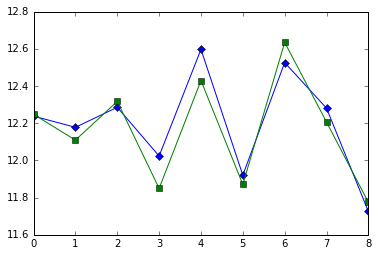

In [22]:
#I want to compare my predictions to the true values
#Lets plot these for the first 10 hourses
plt.plot( yhat[0:9], marker="D")   #and lets compare them to the ground truth
plt.plot( y[0:9], marker="s" ) 

Diamonds are predictions and squares are the true values (log1p of sales price).
This looks pretty good. Lets compute the actual loss

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y,yhat)

0.009169260010864844

That seems pretty small. 
But I am making a mistake here by interpreting this number.
We will explain this later. Maybe you already see the mistake ?

Lets try to compare this ridge model with ordinary least squares (OLS). 

In [22]:
#We want to decide if alpha=0 (i.e. good-old  Ordinary Least squares regression)
#Is better than ridge regression with alpha=0. 
#lets make a model for OLS by setting alpha=0
model_ols= Ridge(alpha=10e-7)  #Alpha is the hyperparameter for the amount of regularization
model_ols.fit(X_train, y)
yhat_ols=model_ols.predict(X_train)  #OLS predictions

So which model is better? yhat or yhat_ols?

In [23]:
mean_squared_error(y,yhat)

0.0091692600108648197

In [24]:
mean_squared_error(y,yhat_ols)

0.0083974669493101558

OLS seems to be better than Ridge regression. 
But this is a mistake. 
We are looking at the train loss. 
A model needs to perform well on data it has not seen before. 
Hence we are Overfitting. We have to train on half the data and test on the other half. 

A better way is to use cross validation.

In [25]:
#How to do cross validation
from sklearn.model_selection import cross_val_score


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    #note that we have minus the negative mean squared error  = MSR. 
    #This is because cross_val_score wants a score, i.e. higher score is better.
    return rmse

In [26]:
rmse_cv(Ridge(alpha = 1))

array([ 0.11383481,  0.13876091,  0.13696888,  0.11193148,  0.15531317])

Cross validation gives you 5 numbers of root mean square (RMSE), not one. 
This is because it trains and computes the error 5 times, on the 5 folds.
You want to average them to estimate your model accuracy.

In [27]:
rmse_cv(Ridge(alpha = 1)).mean()

0.13136184989399563

In [28]:
rmse_cv(Ridge(alpha = 10e-7)).mean()

0.16506291590278818

In [30]:
#insted of making alpha very small, we can also do vanilla OLS
from sklearn import linear_model  #implementation of OLS
reg_ols= linear_model.LinearRegression()
rmse_cv( reg_ols).mean()

0.16524087909049695

Note that Ridge with very small alpha is almost the same as the liner_model implementation of linear regression. 
The small difference is probably because of the way OLS is solved in the two methods. 
If you set alpha to be too small 

In [31]:
#Lets try an XGBoost regressor model
from xgboost import XGBRegressor

my_xgb_lala_model = XGBRegressor()
my_xgb_lala_model.fit(X_train, y, verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
rmse_cv( my_xgb_lala_model).mean()  #this is a little slower

0.13082901229236588

0.1308 is even better than Ridge with alpha =1 (gave 0.1313) 
This is without tuning alpha or the XGB hyperparams. 

In [172]:
#Tuning: lets try various Alphas and do cross validation to see which works better

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

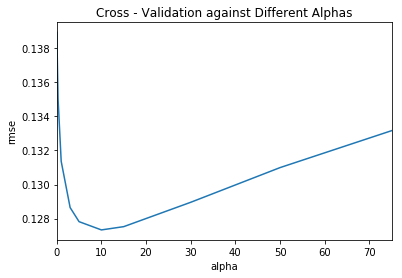

In [173]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Cross - Validation against Different Alphas")
plt.xlabel("alpha")
plt.ylabel("rmse")

It seems that alpha=10 is the optimal amount of regularization for ridge. 
Lets see the performance on CV:

In [174]:
rmse_cv(Ridge(alpha = 10)).mean()

0.12733734668670754

This is better than the XGB regression without tuning. 
But with tuning you can do better. 

We can also "stack" the models by feeding the predictions of one model into another model. If you use the data point label to train on the model, then there is some leakage of the labels when training the second model.

We recommend you continue by studying this notebook 
https://www.kaggle.com/apapiu/regularized-linear-models

HTML Styling commands here.

In [33]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [185]:
%%javascript
javascript:$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>